In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from scipy.signal import find_peaks

#read graph from txt file
def readGraphFrom(file):
    G = nx.read_edgelist(file, create_using=nx.Graph(), nodetype=str, data=(('og_weight', float),))
    return G

def _partialEdgeBetweenness(G):
    #create graph to store partial edge betweenness
    NG = G.copy()
    #choose each node as root once
    for root in G:
        #create ShortestPathGraph
        SPG = nx.Graph()
        #calculate shotest path from each node to root and add edges to SPG
        for vertex in G:
            for shortest_path in nx.all_shortest_paths(G, source=vertex, target=root, weight='og_weight'):
                SPG.add_path(shortest_path)
        
        #copy distances from original graph to shortest path graph
        for edge in SPG.edges:
            SPG.edges[edge]['og_weight'] = G.edges[edge]['og_weight']
                    
        #calculate distance and weight for each node in SPG
        max_distance = 0
        for node in SPG:
            if node == root:
                SPG.nodes[node]['distance'] = 0
                SPG.nodes[node]['weight'] = 1
            else:
                distance = nx.shortest_path_length(SPG, source=root, target=node, weight='og_weight')
                #compute maximal distance from root (needed in later steps)
                if distance > max_distance:
                    max_distance = distance
                SPG.nodes[node]['distance'] = distance
                SPG.nodes[node]['weight'] = len(list(nx.all_shortest_paths(SPG, source=root, target=node, weight='og_weight')))
                
        #calculate partial betweenness scores for leaf edges
        for leaf in SPG:
            if SPG.nodes[leaf]['distance'] == max_distance:
                for node1, node2 in SPG.edges(leaf):
                    if node1 == leaf:
                        neighbor = node2
                    else:
                        neighbor = node1
                    SPG.edges[node1, node2][root] = SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']
                    NG.edges[node1, node2][root] = SPG.nodes[neighbor]['weight']/SPG.nodes[leaf]['weight']
        
        #calculate partial betweenness scores for all other edges by decreasing maximal distance in each iteration
        while max_distance > 1:
            max_distance = max_distance-1
            for node in SPG:
                #only look at nodes at the current distance level
                if SPG.nodes[node]['distance'] == max_distance:
                    for node1, node2 in SPG.edges(node):
                        if node1 == node:
                            neighborUP = node2
                        else:
                            neighborUP = node1
                        if SPG.nodes[neighborUP]['distance'] <= max_distance - 1:
                            sum_of_scores = 0
                            for node11, node22 in SPG.edges(node):
                                if node11 == node:
                                    neighborDOWN = node22
                                else:
                                    neighborDOWN = node11
                                if SPG.nodes[neighborDOWN]['distance'] >= max_distance + 1:
                                    sum_of_scores = sum_of_scores + SPG.edges[neighborDOWN, node][root]
                            #set score for edge from current distance level to one level above (root is at top)
                            SPG.edges[node, neighborUP][root] = (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']
                            NG.edges[node, neighborUP][root] = (1 + sum_of_scores)*SPG.nodes[neighborUP]['weight']/SPG.nodes[node]['weight']
                            
    return NG

#calculate edge betweenness for graph
def edgeBetweenness(G, node1, node2):
    NG = G.copy()
    
    for component in nx.connected_component_subgraphs(NG):
        #recalculate betweenness scores for graph components that contain at least one of the nodes from the last
        #removed edge
        if component.has_node(node1) or component.has_node(node2) or (node1 == 0 and node2 == 0):
            SPG = _partialEdgeBetweenness(component)
            
            for edge in SPG.edges:
                SPG.edges[edge]['weight'] = 0
                for root in SPG:
                    if root in SPG.edges[edge]:
                        SPG.edges[edge]['weight'] = SPG.edges[edge]['weight'] + SPG.edges[edge][root]
                        
            #copy final scores to new graph
            for edge in SPG.edges:
                NG.edges[edge]['weight'] = SPG.edges[edge]['weight']

    return NG

#determine edge with maximal betweenness score
def maxScoreEdge(G):
    maxScore = 0.0
    for edge in G.edges:
        if maxScore < G.edges[edge]['weight']:
            maxScore = G.edges[edge]['weight']
            edgeRemove = edge
    return edgeRemove

#remove edge from graph
def removeEdge(edge, G):
    G.remove_edge(edge[0], edge[1])
    return G

In [2]:
G = readGraphFrom("graph.txt")
#G = nx.karate_club_graph()

for edge in G.edges:
    G.edges[edge]['weight'] = 0
    #G.edges[edge]['og_weight'] = 1

In [3]:
Graphs = [G]
Mod = [nx.algorithms.community.modularity(G, list(nx.connected_components(G)), weight='og_weight')]

num_iter = len(G.edges)
e = (0, 0)
NG = G.copy()

#iterate as many times as there are edges in the graph
while num_iter > 0:
    print("Remaining Edges: ", num_iter)
    num_iter = num_iter - 1
    #calculate edge betweenness and store values in new graph 
    NG = edgeBetweenness(NG, e[0], e[1])
    e = maxScoreEdge(NG)
    removeEdge(e, NG)
    
    #add graph and modularity to list
    Graphs.append(NG)
    Mod.append(nx.algorithms.community.modularity(G, list(nx.connected_components(NG)), weight='og_weight'))

Remaining Edges:  1526
Remaining Edges:  1525
Remaining Edges:  1524
Remaining Edges:  1523
Remaining Edges:  1522
Remaining Edges:  1521
Remaining Edges:  1520
Remaining Edges:  1519
Remaining Edges:  1518
Remaining Edges:  1517
Remaining Edges:  1516
Remaining Edges:  1515
Remaining Edges:  1514
Remaining Edges:  1513
Remaining Edges:  1512
Remaining Edges:  1511
Remaining Edges:  1510
Remaining Edges:  1509
Remaining Edges:  1508
Remaining Edges:  1507
Remaining Edges:  1506
Remaining Edges:  1505
Remaining Edges:  1504
Remaining Edges:  1503
Remaining Edges:  1502
Remaining Edges:  1501
Remaining Edges:  1500
Remaining Edges:  1499
Remaining Edges:  1498
Remaining Edges:  1497
Remaining Edges:  1496
Remaining Edges:  1495
Remaining Edges:  1494
Remaining Edges:  1493
Remaining Edges:  1492
Remaining Edges:  1491
Remaining Edges:  1490
Remaining Edges:  1489
Remaining Edges:  1488
Remaining Edges:  1487
Remaining Edges:  1486
Remaining Edges:  1485
Remaining Edges:  1484
Remaining E

Remaining Edges:  1169
Remaining Edges:  1168
Remaining Edges:  1167
Remaining Edges:  1166
Remaining Edges:  1165
Remaining Edges:  1164
Remaining Edges:  1163
Remaining Edges:  1162
Remaining Edges:  1161
Remaining Edges:  1160
Remaining Edges:  1159
Remaining Edges:  1158
Remaining Edges:  1157
Remaining Edges:  1156
Remaining Edges:  1155
Remaining Edges:  1154
Remaining Edges:  1153
Remaining Edges:  1152
Remaining Edges:  1151
Remaining Edges:  1150
Remaining Edges:  1149
Remaining Edges:  1148
Remaining Edges:  1147
Remaining Edges:  1146
Remaining Edges:  1145
Remaining Edges:  1144
Remaining Edges:  1143
Remaining Edges:  1142
Remaining Edges:  1141
Remaining Edges:  1140
Remaining Edges:  1139
Remaining Edges:  1138
Remaining Edges:  1137
Remaining Edges:  1136
Remaining Edges:  1135
Remaining Edges:  1134
Remaining Edges:  1133
Remaining Edges:  1132
Remaining Edges:  1131
Remaining Edges:  1130
Remaining Edges:  1129
Remaining Edges:  1128
Remaining Edges:  1127
Remaining E

Remaining Edges:  804
Remaining Edges:  803
Remaining Edges:  802
Remaining Edges:  801
Remaining Edges:  800
Remaining Edges:  799
Remaining Edges:  798
Remaining Edges:  797
Remaining Edges:  796
Remaining Edges:  795
Remaining Edges:  794
Remaining Edges:  793
Remaining Edges:  792
Remaining Edges:  791
Remaining Edges:  790
Remaining Edges:  789
Remaining Edges:  788
Remaining Edges:  787
Remaining Edges:  786
Remaining Edges:  785
Remaining Edges:  784
Remaining Edges:  783
Remaining Edges:  782
Remaining Edges:  781
Remaining Edges:  780
Remaining Edges:  779
Remaining Edges:  778
Remaining Edges:  777
Remaining Edges:  776
Remaining Edges:  775
Remaining Edges:  774
Remaining Edges:  773
Remaining Edges:  772
Remaining Edges:  771
Remaining Edges:  770
Remaining Edges:  769
Remaining Edges:  768
Remaining Edges:  767
Remaining Edges:  766
Remaining Edges:  765
Remaining Edges:  764
Remaining Edges:  763
Remaining Edges:  762
Remaining Edges:  761
Remaining Edges:  760
Remaining 

Remaining Edges:  431
Remaining Edges:  430
Remaining Edges:  429
Remaining Edges:  428
Remaining Edges:  427
Remaining Edges:  426
Remaining Edges:  425
Remaining Edges:  424
Remaining Edges:  423
Remaining Edges:  422
Remaining Edges:  421
Remaining Edges:  420
Remaining Edges:  419
Remaining Edges:  418
Remaining Edges:  417
Remaining Edges:  416
Remaining Edges:  415
Remaining Edges:  414
Remaining Edges:  413
Remaining Edges:  412
Remaining Edges:  411
Remaining Edges:  410
Remaining Edges:  409
Remaining Edges:  408
Remaining Edges:  407
Remaining Edges:  406
Remaining Edges:  405
Remaining Edges:  404
Remaining Edges:  403
Remaining Edges:  402
Remaining Edges:  401
Remaining Edges:  400
Remaining Edges:  399
Remaining Edges:  398
Remaining Edges:  397
Remaining Edges:  396
Remaining Edges:  395
Remaining Edges:  394
Remaining Edges:  393
Remaining Edges:  392
Remaining Edges:  391
Remaining Edges:  390
Remaining Edges:  389
Remaining Edges:  388
Remaining Edges:  387
Remaining 

Remaining Edges:  56
Remaining Edges:  55
Remaining Edges:  54
Remaining Edges:  53
Remaining Edges:  52
Remaining Edges:  51
Remaining Edges:  50
Remaining Edges:  49
Remaining Edges:  48
Remaining Edges:  47
Remaining Edges:  46
Remaining Edges:  45
Remaining Edges:  44
Remaining Edges:  43
Remaining Edges:  42
Remaining Edges:  41
Remaining Edges:  40
Remaining Edges:  39
Remaining Edges:  38
Remaining Edges:  37
Remaining Edges:  36
Remaining Edges:  35
Remaining Edges:  34
Remaining Edges:  33
Remaining Edges:  32
Remaining Edges:  31
Remaining Edges:  30
Remaining Edges:  29
Remaining Edges:  28
Remaining Edges:  27
Remaining Edges:  26
Remaining Edges:  25
Remaining Edges:  24
Remaining Edges:  23
Remaining Edges:  22
Remaining Edges:  21
Remaining Edges:  20
Remaining Edges:  19
Remaining Edges:  18
Remaining Edges:  17
Remaining Edges:  16
Remaining Edges:  15
Remaining Edges:  14
Remaining Edges:  13
Remaining Edges:  12
Remaining Edges:  11
Remaining Edges:  10
Remaining Edg

In [8]:
#for g in Graphs:
#    print("Components:")
#    print(list(nx.connected_components(g)))
#    print(g.edges)
               
#for mod in Mod:
#    print("Modularity:")
#    print(mod)

Communities with local maximal modularity:
Number of removed edges:  7
Modularity:
0.9825901895157408
Communities:
[{'fd8aab26d9d60fa9', '3e14755be8fb6d2b', '04564634a13cfe18', '22878bb7c8e36cee'}, {'2102d1f1238117f5', '985d460dd0824d1f', 'b12a133e828edaa6', '7f32e99a32fc1c1c', 'bfcd2a1c8d33081f', '8dfea3396c3ad262', '48a86db8e2370425', '2afc5fab21b980a4', '6dd46b6d06209f25', '1cc3c636b852dd3a'}, {'4f01900a95f557ed', 'b5757e2724fd1b9b'}, {'f5b14250a333e307', 'd76c7910de2b3775', 'ced4f23e35ef19e3', '5bddb757fdbae201', 'f40fc97891f1c56e', '0cd9db96c1a2468f', '0530df5da0f6cccb', 'a5664ea38c840240', '0174d831a8191650', 'e6542f81434ab7fd', '1e04f1e989f7eb3a', '22ac7dc718931bbb', '4a6bf0543a70a945', '6fbd36dd72b9c8ee', '6a25bd8591e4d2ba', '334355a2cec8badf', '64d1041c17832ba0', '135e02db4b6406ea', 'a4d60bfd56f329ab', 'de313c749cce8109', 'cf3c55e8a2ecac1c', 'cb03f2b65b98ddc4', 'a4337353dbad4461', '153e04c866671b9c', '01273a83c94d5def', '8125703c773c9949', 'e95dc692e32e7461', 'a8e69f9cdce1e4d1

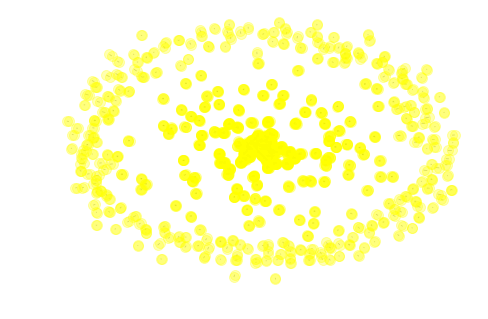

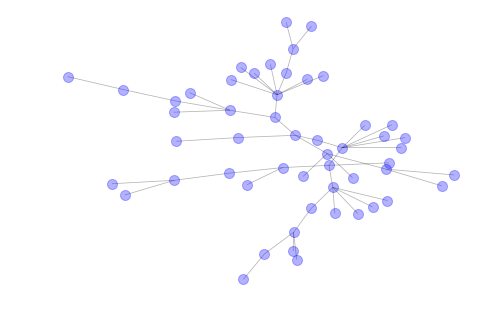

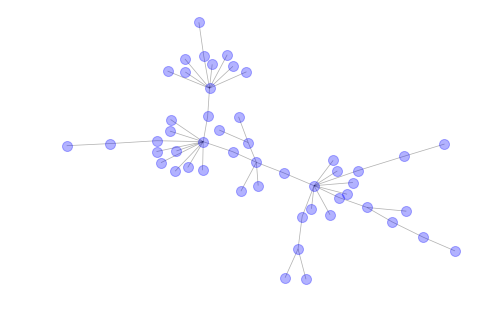

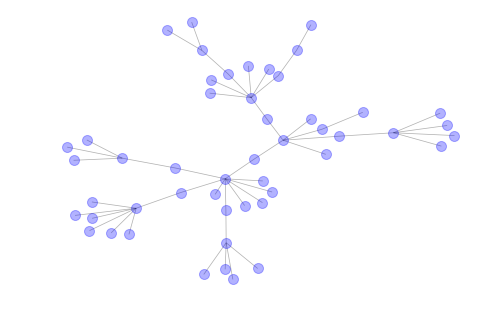

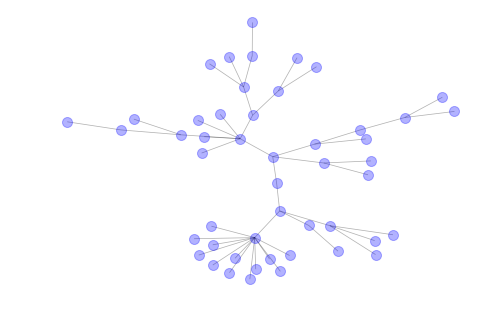

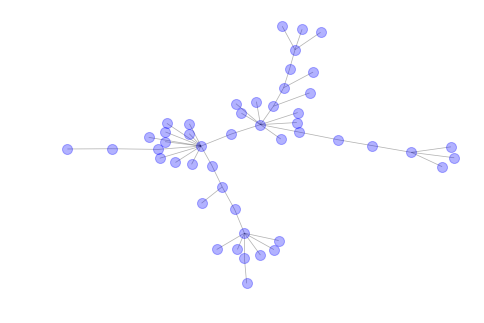

In [9]:
print("Communities with local maximal modularity:")

#find local maxima in modularity array
index_max_mod_np, _ = find_peaks(Mod)
index_max_mod = index_max_mod_np.tolist()

if not index_max_mod:
#    index_max_mod.append(0)
    index_max_mod.append(1)

options = {'node_color': 'yellow', 'node_size': 100, 'width': 0.75, 'alpha': 0.3}
    
#print modularity and communities for local maxima
for i in index_max_mod:
    print("Number of removed edges: ", i)
    print("Modularity:")
    print(Mod[i])
    print("Communities:")
    print(list(nx.connected_components(Graphs[i])))
    
    
    outputfile = "output30secstep" + str(i) + ".txt"
    nx.write_edgelist(Graphs[i], outputfile)

    nx.draw_spring(Graphs[i], **options)
    plt.savefig("graph.pdf")
    plt.show()
    
    options = {'node_color': 'blue', 'node_size': 100, 'width': 0.75, 'alpha': 0.3}
    
    giant = sorted(nx.connected_component_subgraphs(Graphs[i]), key=len, reverse=True)
    giant_components = 5
    
    if len(giant) < giant_components:
        giant_components = len(giant)
    
    i = 0
    while i < giant_components:
        nx.draw_spring(giant[i], **options)
        filename = "giant" + str(i) + ".pdf"
        plt.savefig(filename)
        plt.show()
        i = i+1
    
    #for component in nx.connected_component_subgraphs(Graphs[i]):
    #    nx.draw_spectral(component, with_labels=True, **options)
    #    plt.show()

In [10]:
for i in index_max_mod:
    result = list(sorted(nx.connected_components(Graphs[i]), key=len, reverse=True))
    print("Size of components: ")
    for comp in result:
        print(len(comp))

Size of components: 
53
51
50
49
49
43
42
41
40
37
33
29
25
24
22
21
20
20
17
16
15
14
14
13
12
12
12
11
11
11
10
10
10
10
10
10
9
8
8
8
8
8
8
7
7
7
7
7
7
7
7
7
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [11]:
def most_central_edge(G):
    centrality = nx.edge_betweenness_centrality(G, weight='og_weight')
    return max(centrality, key=centrality.get)

#comp = nx.community.girvan_newman(G)
#print(tuple(sorted(c) for c in next(comp)))

comp = list(nx.community.girvan_newman(G, most_valuable_edge=most_central_edge))
c0 = comp[0]
c1 = comp[1]
c2 = comp[2]
c3 = comp[3]
c4 = comp[4]

result = sorted(c0, key=len, reverse=True)
print("Size of components: ")
for comp in result:
    print(len(comp))
    
result = sorted(c1, key=len, reverse=True)
print("Size of components: ")
for comp in result:
    print(len(comp))
    
result = sorted(c2, key=len, reverse=True)
print("Size of components: ")
for comp in result:
    print(len(comp))
    
result = sorted(c3, key=len, reverse=True)
print("Size of components: ")
for comp in result:
    print(len(comp))
    
result = sorted(c4, key=len, reverse=True)
print("Size of components: ")
for comp in result:
    print(len(comp))


KeyboardInterrupt: 